In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter
import utils
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LinearRegression
from itertools import combinations
import random
from sklearn import metrics
from tqdm import tqdm_notebook
import re
import jieba
import json
plt.rcParams["font.family"] = "SimHei"

sns.set_context("notebook")
sns.set_style("ticks")
%matplotlib inline

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]

In [14]:
colors = ["#CD5B4D", "#F7CE5F", "#4F9F66"]
# snscolors = ['#A93537', '#3D71AB']
blue = sns.color_palette("Blues", 5)[-2]
red = sns.color_palette("Reds", 5)[-2]

def plot_dist(dlist, vlist, label="", offset=0, color=None, hatch=None):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    
    plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color=color, label=label)
    if hatch:
        plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color="None", edgecolor='k', hatch=hatch)

    plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def plot_dist_field(dlist, vlist, label="", offset=0, color="r", colorgroup="Reds"):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    blues = sns.color_palette("Blues", len(vlist))
    with sns.color_palette(colorgroup, len(vlist)) as tcolor:
        for ti, tv in enumerate(dist_vec):
            plt.bar(np.array([ti])+offset, [tv], width=1., label=str(ti+1), color=tcolor[ti] if ti > 2 else blues[ti])
            # print (round(tv*100,1))
            plt.text(ti + offset, tv+0.02, "{}%".format(round(tv*100,1)), horizontalalignment='center', verticalalignment='center')
    # plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def calculate_pvalues(df, fun=pearsonr):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(fun(df[r], df[c])[1], 4)
    return pvalues

def ifdiff(dlist1, dlist2, fun=ttest_ind):
    pv = ttest_ind(dlist1.dropna(), dlist2.dropna())[1]
    return pv

def stats(dlist):
    return np.mean(dlist), np.var(dlist), np.max(dlist)

def plot_heatmap(tmat, axis=0, reverse_y=True, xticks=range(1, 6), yticks=range(1, 6), vmax=None):
    # axis=0: 按列归一化; axis=1: 按行归一化
    plotmat = tmat.copy()
    if axis == 0:
        tdiv = np.sum(plotmat, axis=0)
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv
    else:
        tdiv = np.sum(plotmat, axis=1).reshape((plotmat.shape[0], 1))
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv

    plotmat[np.isnan(plotmat)] = 0.0
    if reverse_y:
        sns.heatmap(plotmat[::-1,:], annot=True, cmap="Blues", vmax=vmax)
        plt.yticks(np.arange(plotmat.shape[0])+0.5, yticks[::-1])
    plt.xticks(np.arange(plotmat.shape[0])+0.5, xticks)
    
def plot_change_mat(x, y, data):
    tmat = np.zeros((5, 5))
    for tv1, tv2 in zip(data[y], data[x]):
        tmat[int(tv1)-1, int(tv2)-1] += 1
    plot_heatmap(tmat, axis=0, reverse_y=True, vmax=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    
def compare(df1, df2, keys, plimit=1.0, fun=ttest_ind):
    recs = []
    anskeys = []
    for tk in keys:
        try:
            tp = ifdiff(df1[tk], df2[tk], fun=fun)
            recs.append((np.mean(df1[tk]), np.mean(df2[tk]), tp if tp <= plimit else np.nan))
            anskeys.append(tk)
        except:
            pass
    df_ans = pd.DataFrame.from_records(recs, columns=['left', 'right', 'p-value'], index=anskeys)
    return df_ans

def pcc(dlist1, dlist2):
    idx = (pd.isnull(dlist1) == False) & (pd.isnull(dlist2) == False)
    return pearsonr(dlist1[idx], dlist2[idx])

def plot_scatter(x, y, data, color, reg=False):
    tdf = data.copy().dropna()
    plt.scatter(tdf[x], tdf[y], color=color)
    if reg:
        lr = LinearRegression()
        x = np.array(tdf[x]).reshape((len(tdf), 1))
        y = np.array(tdf[y]).reshape((len(tdf), 1)) 
        lr.fit(x, y)
        plt.plot([[np.min(x)], [np.max(x)]], lr.predict([[np.min(x)], [np.max(x)]]), color=color)
    
def ctr(tdf):
    return sum(tdf['ifclick']) / float(len(tdf))

def is_outlier(points, threshold=3.5):
    if len(points.shape) == 1:
        points = points[:,None]

    median = np.median(points, axis=0)

    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # 中位数绝对偏差
    med_abs_deviation = np.median(diff)

    # compute modified Z-score
    # http://www.itl.nist.gov/div898/handbook/eda/section4/eda43.htm#Iglewicz
    modified_z_score = 0.6745 * diff / med_abs_deviation

    # return a mask for each outlier
    return modified_z_score > threshold

In [15]:
df_explanation = pd.read_pickle("df_explanation.pkl")

df_explanation['change2_watch_intent'] = df_explanation['exam_watch_intent'] - df_explanation['after_watch_intent']
df_explanation['change2_expected_preference'] = df_explanation['exam_expected_preference'] - df_explanation['after_expected_preference']
df_explanation['match_peer_pos'] = df_explanation['match_peer_pos'].astype(np.float64)
df_explanation['match_peer_neg'] = df_explanation['match_peer_neg'].astype(np.float64)

umean = df_explanation.groupby("user_id")['satisfaction'].apply(lambda t: np.mean(t)).to_dict()
ustd = df_explanation.groupby("user_id")['satisfaction'].apply(lambda t: np.std(t)).to_dict()
def zscore(user_id, sat_score):
    return (sat_score - umean[user_id]) / ustd[user_id]

df_explanation['satisfaction_zscore'] = list(map(lambda t: zscore(t[0], t[1]), zip(df_explanation['user_id'], df_explanation['satisfaction'])))

In [46]:
# Statistics
# len(set([(u, i) for u, i in zip(df_explanation['user_id'], df_explanation['movie_id'])]))

len(df_explanation[df_explanation['explanation_type'] == "peer"])

310

# Figure 1

In [16]:
idx_user = df_explanation['explanation_type'] == "user"
idx_item = df_explanation['explanation_type'] == "item"
idx_itempeer = df_explanation['explanation_type'] == "item_peer"
idx_pop = df_explanation['explanation_type'] == "pop"
idx_attr = df_explanation['explanation_type'].map(lambda t: t[:4] == "attr")
idx_peer = df_explanation['explanation_type'] == "peer"

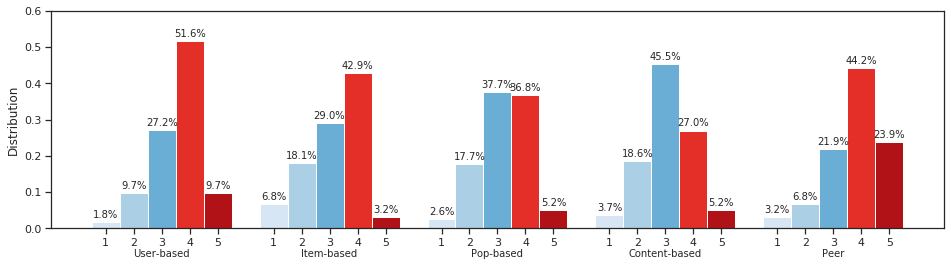

In [18]:
plt.figure(figsize=(16, 4))
plot_dist_field(df_explanation[idx_user]['satisfaction'], range(1, 6), label="User")
plot_dist_field(df_explanation[idx_item]['satisfaction'], range(1, 6), offset=6, label="Item")
plot_dist_field(df_explanation[idx_pop]['satisfaction'], range(1, 6), offset=12)
plot_dist_field(df_explanation[idx_attr]['satisfaction'], range(1, 6), offset=18)
plot_dist_field(df_explanation[idx_peer]['satisfaction'], range(1, 6), offset=24)

plt.text(2, -0.07, "User-based", horizontalalignment='center', verticalalignment='center')
plt.text(8, -0.07, "Item-based", horizontalalignment='center', verticalalignment='center')
plt.text(14, -0.07, "Pop-based", horizontalalignment='center', verticalalignment='center')
plt.text(20, -0.07, "Content-based", horizontalalignment='center', verticalalignment='center')
plt.text(26, -0.07, "Peer", horizontalalignment='center', verticalalignment='center')


lx = list(range(5)) + list(range(6, 11)) + list(range(12, 17)) + list(range(18, 23)) + list(range(24, 29))
ly = list(range(1, 6)) + list(range(1, 6)) + list(range(1, 6)) + list(range(1, 6)) + list(range(1, 6))
plt.xticks(lx, ly)
plt.ylim(0.0, 0.6)
plt.ylabel("Distribution")

plt.savefig("figures/sat_dist_1.pdf", bbox_inches="tight", dpi=100)

# Figure 1

In [6]:
idx_dict = {
    "User": df_explanation['explanation_type'] == "user",
    "Item": df_explanation['explanation_type'] == "item",
    "Item(peer)": df_explanation['explanation_type'] == "item_peer",
    "Pop": df_explanation['explanation_type'] == "pop",
    "Content": df_explanation['explanation_type'].map(lambda t: t[:4] == "attr"),
    "Peer": df_explanation['explanation_type'] == "peer"
}
results = {}
for tk in idx_dict:
    tr = utils.Ratio(df_explanation[idx_dict[tk]]['satisfaction'])
#     total = float(sum(tcnt.values()))
    results[tk] = [round(tr[t] * 100, 2) for t in range(1, 6)]
results

{'User': [1.79, 9.68, 27.24, 51.61, 9.68],
 'Item': [6.77, 18.06, 29.03, 42.9, 3.23],
 'Item(peer)': [4.42, 9.73, 29.2, 45.13, 11.5],
 'Pop': [2.58, 17.74, 37.74, 36.77, 5.16],
 'Content': [3.71, 18.62, 45.47, 27.02, 5.19],
 'Peer': [3.23, 6.77, 21.94, 44.19, 23.87]}

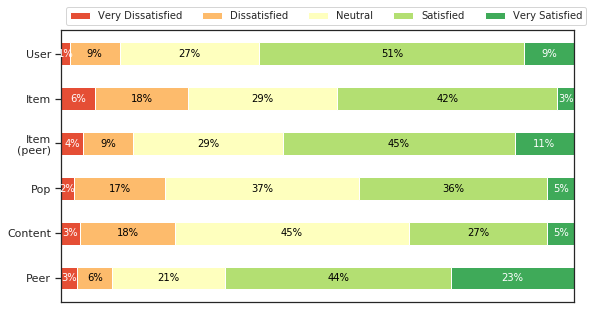

In [7]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['Very Dissatisfied', 'Dissatisfied',
                  'Neutral', 'Satisfied', 'Very Satisfied']
results = {'User': [1.79, 9.68, 27.24, 51.61, 9.68],
 'Item': [6.77, 18.06, 29.03, 42.9, 3.23],
 'Item\n(peer)': [4.42, 9.73, 29.2, 45.13, 11.5],
 'Pop': [2.58, 17.74, 37.74, 36.77, 5.16],
 'Content': [3.71, 18.62, 45.47, 27.02, 5.19],
 'Peer': [3.23, 6.77, 21.94, 44.19, 23.87]}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.2 else 'k'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, "{}%".format(str(int(c))), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=10)

    return fig, ax


survey(results, category_names)
# plt.show()
plt.savefig("figures/sat_dist_2.pdf", bbox_inches="tight", dpi=100)

# Figure 2

    subplot: self, peer
    x: watch intention
    y: pos, neg, normal

In [19]:
df_uitem = df_explanation.drop_duplicates(subset=["user_id", "movie_id"]).copy()
df_uitem.reset_index(drop=True, inplace=True)

In [20]:
df_explanation.columns

Index(['user_id', 'movie_id', 'explanation_type', 'explanation',
       'before_click_intent', 'before_watch_intent',
       'before_expected_preference', 'after_click_intent',
       'after_watch_intent', 'after_expected_preference', 'exam_watch_intent',
       'exam_expected_preference', 'persuasiveness', 'transparency',
       'pre_knowledge', 'interest_accuracy', 'satisfaction', 'evaluate_reason',
       'rouge-1', 'rouge-2', 'rouge-L', 'self_explanation', 'self_attributes',
       'self_pos', 'self_normal', 'self_neg', 'peer_summary_ans',
       'rank_result', 'rank_result_type', 'match_self', 'match_self_pos',
       'match_self_neg', 'match_self_normal', 'change_click_intent',
       'change_watch_intent', 'change_expected_preference', 'peer_id',
       'movie_title', 'peer_similar_movie', 'peer_attributes', 'peer_pos',
       'peer_normal', 'peer_neg', 'peer_preference', 'peer_explanation_short',
       'peer_confidence', 'peer_explanation_long', 'peer_best_attribute',
       '

In [21]:
df_uitem['self_pos_cnt'] = df_uitem['self_pos'].map(lambda t: len(t))
df_uitem['self_neg_cnt'] = df_uitem['self_neg'].map(lambda t: len(t))
df_uitem['self_normal_cnt'] = df_uitem['self_normal'].map(lambda t: len(t))
df_uitem['peer_pos_cnt'] = df_uitem['peer_pos'].map(lambda t: len(t))
df_uitem['peer_neg_cnt'] = df_uitem['peer_neg'].map(lambda t: len(t))
df_uitem['peer_normal_cnt'] = df_uitem['peer_normal'].map(lambda t: len(t))

In [22]:
def plot_change(data, colx, coly, label, color, xrange=range(1, 6)):
    def yerr(X):
        n = len(X)
        X_mean = np.mean(X)
        X_std = np.std(X)
        X_se = X_std / np.sqrt(n)
        return X_se
    
    ychange = [np.mean(data[data[colx] == tx][coly]) for tx in xrange]
    print (np.min(ychange) - 0.2*(np.max(ychange)-np.min(ychange)), np.max(ychange) + 0.2*(np.max(ychange)-np.min(ychange)))
    yerr = [yerr(data[data[colx] == tx][coly]) for tx in xrange]
    
    plt.errorbar(xrange, ychange, yerr=yerr, marker="o", label=label, color=color)

1.8608950843727072 6.938077769625825
7.229787234042553 10.461702127659574
-0.07747615553925166 1.5818782098312547
2.6740278796771824 5.921349963316214
7.959410801963993 11.147790507364975
0.10450928381962868 0.9883289124668434


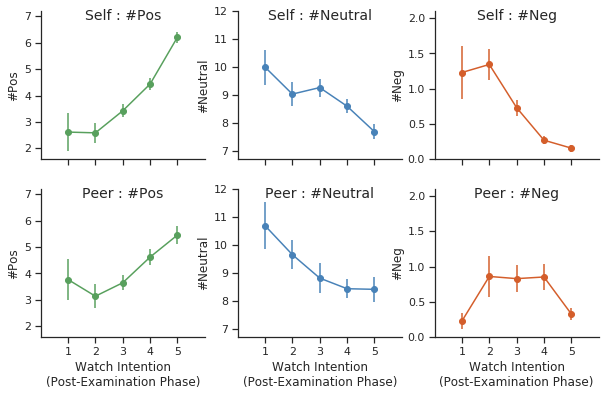

In [27]:
plt.figure(figsize=(10, 6))
colors = ["#58A05D", "#4882B8", "#D45E2B"]
cols = ["self_pos_cnt", "self_normal_cnt", "self_neg_cnt"]
names = ['#Pos', '#Neutral', '#Neg']
yrange = [(1.58, 7.2), (6.7, 12), (0, 2.1)]

for ti, tlabel in enumerate(cols):
    ax = plt.subplot(2, 3, ti + 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plot_change(df_uitem, "exam_watch_intent", tlabel, names[ti], color=colors[ti])
    plt.ylim(yrange[ti][0], yrange[ti][1])
    plt.xlim(0, 6)
    plt.xticks(range(1, 6), ["", "", "", "", "", ""])
    plt.title("Self : " + names[ti], fontsize=14, y=0.9)
    plt.ylabel(names[ti])
    
colors = ["#58A05D", "#4882B8", "#D45E2B"]
cols = ["peer_pos_cnt", "peer_normal_cnt", "peer_neg_cnt"]
names = ['#Pos', '#Neutral', '#Neg']
yrange = [(1.58, 7.2), (6.7, 12), (0, 2.1)]
for ti, tlabel in enumerate(cols):
    ax = plt.subplot(2, 3, 3 + ti + 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plot_change(df_uitem, "exam_watch_intent", tlabel, names[ti], color=colors[ti])
    plt.ylim(yrange[ti][0], yrange[ti][1])
    plt.xlim(0, 6)
    plt.xticks(range(1, 6), range(1, 6))
    plt.title("Peer : " + names[ti], fontsize=14, y=0.9)
    plt.ylabel(names[ti])
    plt.xlabel("Watch Intention\n(Post-Examination Phase)")
    
plt.savefig("figures/annotation_cnt.pdf", bbox_inches="tight", dpi=100)

# Figure (not used)

In [52]:
df_explanation['match_peer_score'] = df_explanation['match_peer_pos'] - df_explanation['match_peer_neg']
df_explanation['match_self_score'] = df_explanation['match_self_pos'].astype(float) - df_explanation['match_self_neg'].astype(float)

In [351]:
df_type = df_explanation.groupby("explanation_type").mean()

In [149]:
show_types = ['attr_nonpersonal', 'attr_random', 'attr_personal', 'attr_peer', 'item', 'item_peer', 'pop']
df_ans = df_type.loc[show_types, ['satisfaction'] + ['match_pos', 'match_neg', 'match_peer_pos', 'match_peer_neg', 'match_peer_score', 'match_score']]

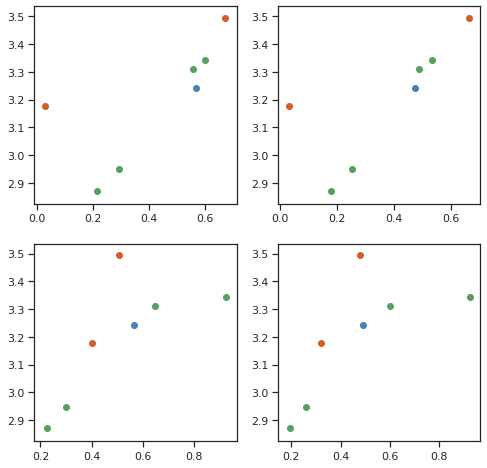

In [150]:
def plot_scater(data, metric):
    show_types = ['attr_nonpersonal', 'attr_random', 'attr_personal', 'attr_peer', 'item', 'item_peer', 'pop']
    show_colors = ["#58A05D", "#58A05D", "#58A05D", "#58A05D", "#D45E2B", "#D45E2B", "#4882B8"]
    for ti, ttype in enumerate(show_types):
        plt.scatter(df_ans.loc[[ttype], metric], df_ans.loc[[ttype], ['satisfaction']], color=show_colors[ti])
    

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_scater(df_ans, "match_pos")

plt.subplot(2, 2, 2)
plot_scater(df_ans, "match_score")

plt.subplot(2, 2, 3)
plot_scater(df_ans, "match_peer_pos")

plt.subplot(2, 2, 4)
plot_scater(df_ans, "match_peer_score")

# Table 1

In [11]:
idxdic = {
    "content": df_explanation['explanation_type'].map(lambda t: t[:4] == "attr"),
    "pop": df_explanation['explanation_type'] == "pop",
    "item": df_explanation['explanation_type'].map(lambda t: t[:4] == "item")
}

idx_sat = df_explanation['satisfaction'] > 3
idx_normal = df_explanation['satisfaction'] == 3
idx_dsat = df_explanation['satisfaction'] < 3 

ds_ans = utils.PDtable()
for texpl in ['content', 'pop', 'item']:
    
    ds_ans.add(texpl, "type")
    ds_ans.add("dsat", "satisfaction")
    ds_ans.add(sum(idxdic[texpl] & idx_dsat) / float(sum(idxdic[texpl])), "cnt")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_dsat]['match_self_pos']), "pos")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_dsat]['match_self_normal']), "normal")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_dsat]['match_self_neg']), "neg")
    
    ds_ans.add(texpl, "type")
    ds_ans.add("normal", "satisfaction")
    ds_ans.add(sum(idxdic[texpl] & idx_normal) / float(sum(idxdic[texpl])) , "cnt")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_normal]['match_self_pos']), "pos")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_normal]['match_self_normal']), "normal")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_normal]['match_self_neg']), "neg")
        
    ds_ans.add(texpl, "type")
    ds_ans.add("sat", "satisfaction")
    ds_ans.add(sum(idxdic[texpl] & idx_sat) / float(sum(idxdic[texpl])), "cnt")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_sat]['match_self_pos']), "pos")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_sat]['match_self_normal']), "normal")
    ds_ans.add(np.mean(df_explanation[idxdic[texpl] & idx_sat]['match_self_neg']), "neg")
    

df_ans = ds_ans.to_pandas()

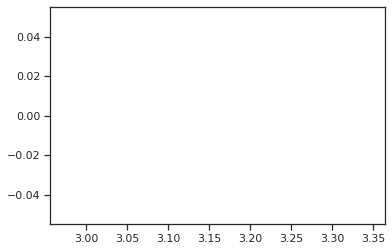

In [27]:
def kdeplot(dlist):
    sns.distplot([t for t in dlist if not pd.isnull(t)], kde=False, hist=False)
    
kdeplot(df_explanation[df_explanation['match_peer_neg'] == 1]['satisfaction'])
kdeplot(df_explanation[df_explanation['match_peer_normal'] == 1]['satisfaction'])
kdeplot(df_explanation[df_explanation['match_peer_pos'] == 1]['satisfaction'])

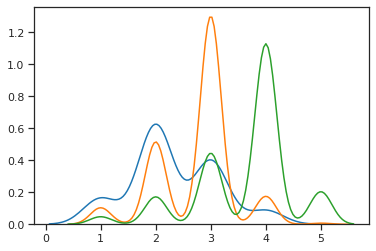

In [23]:
kdeplot(df_explanation[df_explanation['match_self_neg'] == 1]['satisfaction'])
kdeplot(df_explanation[df_explanation['match_self_normal'] == 1]['satisfaction'])
kdeplot(df_explanation[df_explanation['match_self_pos'] == 1]['satisfaction'])

In [109]:
df_explanation.columns

Index(['user_id', 'movie_id', 'explanation_type', 'explanation',
       'before_click_intent', 'before_watch_intent',
       'before_expected_preference', 'after_click_intent',
       'after_watch_intent', 'after_expected_preference', 'exam_watch_intent',
       'exam_expected_preference', 'persuasiveness', 'transparency',
       'pre_knowledge', 'interest_accuracy', 'satisfaction', 'evaluate_reason',
       'match_pos', 'match_normal', 'match_neg', 'attr_match_pos',
       'attr_match_neg', 'other_match_pos', 'other_match_neg', 'rouge-1',
       'rouge-2', 'rouge-L', 'self_explanation', 'self_attributes', 'self_pos',
       'self_normal', 'self_neg', 'peer_summary_ans', 'change_click_intent',
       'change_watch_intent', 'change_expected_preference', 'peer_id',
       'movie_title', 'peer_similar_movie', 'peer_attributes', 'peer_pos',
       'peer_normal', 'peer_neg', 'peer_preference', 'peer_explanation_short',
       'peer_confidence', 'peer_explanation_long', 'peer_best_attribute'

# Table 2

In [34]:
idxdic = {
    "content": df_explanation['explanation_type'].map(lambda t: t[:4] == "attr"),
    "pop": df_explanation['explanation_type'] == "pop",
    "item": df_explanation['explanation_type'].map(lambda t: t[:4] == "item")
}

In [40]:
# prediction
def evaluate_cls(y_truth, y_pred):
    ans = {
        "acc": metrics.accuracy_score(y_truth, y_pred),
        "f1": metrics.f1_score(y_truth, y_pred, average="micro"),
        "p": metrics.precision_score(y_truth, y_pred, average=None),
        "r": metrics.recall_score(y_truth, y_pred, average=None)
    }
    return ans
def predict_by_matchness(metric, negative=False):
    return [t if not negative else not t for t in metric]

metric_reverse = [("match_self_pos", False), 
                  ("match_self_normal", True), 
                  ("match_self_neg", True), 
                  ("match_peer_pos", False), 
                  ("match_peer_normal", True), 
                  ("match_peer_neg", True)]

ds_pointlevel = utils.PDtable()
for tm, tn in metric_reverse:
    ds_pointlevel.add((tm, tn), "method")
    
    for ttype in ['content', 'pop', 'item']:
        data = df_explanation[idxdic[ttype]]
        
        tpred = predict_by_matchness(data[tm], tn)
        tsc = evaluate_cls(data['satisfaction'] > 3, tpred)

        ds_pointlevel.add(tsc['acc'], "{}_acc".format(ttype))
        # ds_pointlevel.add(tsc['p'], "{}_p".format(ttype))
        # ds_pointlevel.add(tsc['r'], "{}_r".format(ttype))
        # ds_pointlevel.add(tsc['f1'], "{}_f1".format(ttype))
    
df_pointlevel = ds_pointlevel.to_pandas()
df_pointlevel

,method,content_acc,pop_acc,item_acc
0,"(match_self_pos, False)",0.841845,0.796774,0.645390
1,"(match_self_normal, True)",0.794893,0.709677,0.635934
2,"(match_self_neg, True)",0.369028,0.506452,0.498818
3,"(match_peer_pos, False)",0.615321,0.564516,0.560284
4,"(match_peer_normal, True)",0.602142,0.516129,0.555556
5,"(match_peer_neg, True)",0.335255,0.467742,0.494090


In [58]:
# regression
def evaluate_reg(y_truth, y_pred):
    tpcc, tp = pearsonr(y_pred, y_truth)
    ans = {
        "mse": metrics.mean_squared_error(y_truth, y_pred),
        "mae": metrics.mean_absolute_error(y_truth, y_pred),
        "pcc": [round(tpcc, 4), "**" if tp < 0.01 else "*" if tp < 0.05 else ""]
    }
    return ans
def predict_by_matchness(metric, negative=False):
    return [t if not negative else not t for t in metric]

metric_reverse = [("match_self_pos", False), 
                  ("match_self_normal", True), 
                  ("match_self_neg", True), 
                  ("match_self_score", False),
                  ("match_peer_pos", False), 
                  ("match_peer_normal", True), 
                  ("match_peer_neg", True),
                  ("match_peer_score", False)]

ds_pointlevel = utils.PDtable()
for tm, tn in metric_reverse:
    ds_pointlevel.add((tm, tn), "method")
    
    for ttype in ['content', 'pop', 'item']:
        data = df_explanation[idxdic[ttype]]
        
        tpred = predict_by_matchness(data[tm], tn)
        tsc = evaluate_reg(data['satisfaction'], tpred)

        # ds_pointlevel.add(tsc['mse'], "{}_mse".format(ttype))
        # ds_pointlevel.add(tsc['mae'], "{}_mae".format(ttype))
        ds_pointlevel.add(tsc['pcc'][0], "{}_pcc".format(ttype))
        ds_pointlevel.add(tsc['pcc'][1], "{}_pcc_p".format(ttype))
    
df_pointlevel = ds_pointlevel.to_pandas()
df_pointlevel.round(4)

,method,content_pcc,content_pcc_p,pop_pcc,pop_pcc_p,item_pcc,item_pcc_p
0,"(match_self_pos, False)",0.5746,**,0.5929,**,0.2616,**
1,"(match_self_normal, True)",0.4851,**,0.3514,**,0.2360,**
2,"(match_self_neg, True)",0.1817,**,0.4278,**,0.1121,*
3,"(match_self_score, False)",0.5576,**,0.6293,**,0.2700,**
4,"(match_peer_pos, False)",0.2431,**,0.1798,**,0.1082,*
5,"(match_peer_normal, True)",0.2475,**,0.0910,,0.1054,*
6,"(match_peer_neg, True)",-0.0104,,0.1733,**,0.0033,
7,"(match_peer_score, False)",0.2153,**,0.2132,**,0.0902,


In [55]:
df_explanation.columns

Index(['user_id', 'movie_id', 'explanation_type', 'explanation',
       'before_click_intent', 'before_watch_intent',
       'before_expected_preference', 'after_click_intent',
       'after_watch_intent', 'after_expected_preference', 'exam_watch_intent',
       'exam_expected_preference', 'persuasiveness', 'transparency',
       'pre_knowledge', 'interest_accuracy', 'satisfaction', 'evaluate_reason',
       'rouge-1', 'rouge-2', 'rouge-L', 'self_explanation', 'self_attributes',
       'self_pos', 'self_normal', 'self_neg', 'peer_summary_ans',
       'rank_result', 'rank_result_type', 'match_self', 'match_self_pos',
       'match_self_neg', 'match_self_normal', 'change_click_intent',
       'change_watch_intent', 'change_expected_preference', 'peer_id',
       'movie_title', 'peer_similar_movie', 'peer_attributes', 'peer_pos',
       'peer_normal', 'peer_neg', 'peer_preference', 'peer_explanation_short',
       'peer_confidence', 'peer_explanation_long', 'peer_best_attribute',
       '

In [57]:
# regression
def evaluate_reg(y_truth, y_pred):
    tpcc, tp = pearsonr(y_pred, y_truth)
    ans = {
        "mse": metrics.mean_squared_error(y_truth, y_pred),
        "mae": metrics.mean_absolute_error(y_truth, y_pred),
        "pcc": [round(tpcc, 4), "**" if tp < 0.01 else "*" if tp < 0.05 else ""]
    }
    return ans
def predict_by_matchness(metric, negative=False):
    return [t if not negative else not t for t in metric]

metric_reverse = [("rouge-1", False), 
                  ("rouge-2", False), 
                  ("rouge-L", False)]

ds_pointlevel = utils.PDtable()
for tm, tn in metric_reverse:
    ds_pointlevel.add((tm, tn), "method")
    
    
    data = df_explanation[df_explanation["explanation_type"] == "peer"]

    tpred = predict_by_matchness(data[tm], tn)
    tsc = evaluate_reg(data['satisfaction'], tpred)

    # ds_pointlevel.add(tsc['mse'], "{}_mse".format(ttype))
    # ds_pointlevel.add(tsc['mae'], "{}_mae".format(ttype))
    ds_pointlevel.add(tsc['pcc'][0], "{}_pcc".format(ttype))
    ds_pointlevel.add(tsc['pcc'][1], "{}_pcc_p".format(ttype))
    
df_pointlevel = ds_pointlevel.to_pandas()
df_pointlevel.round(4)

,method,item_pcc,item_pcc_p
0,"(rouge-1, False)",0.1522,**
1,"(rouge-2, False)",0.1186,*
2,"(rouge-L, False)",0.1654,**


# Pair-wise

In [502]:
def __compare(ta, tb):
    return False if ta < tb else 0 if ta == tb else True if ta > tb else np.nan

def compare_by_metric(data, pairs, metric):
    ans = []
    for ta, tb in pairs:
        ans.append(__compare(data.loc[ta][metric], data.loc[tb][metric]))
    return ans

def evaluate(y_truth, y_pred):
    ans = {
        "acc": metrics.accuracy_score(y_truth, y_pred),
        "f1": metrics.f1_score(y_truth, y_pred, average="macro"),
        #"p": metrics.precision_score(y_truth, y_pred),
        #"r": metrics.recall_score(y_truth, y_pred)
    }
    return ans

In [489]:
data['match_self_score'] = data['match_self_pos'].astype(int) - data['match_self_neg'].astype(int)
data['match_peer_score'] = data['match_peer_pos'].astype(int) - data['match_peer_neg'].astype(int)

In [504]:
# pairwise

def __compare(ta, tb):
    return -1 if ta < tb else 0 if ta == tb else 1 if ta > tb else np.nan


def build_pairwise_dataset(data):
    def get_pair(idlist, vlist):
        tans_ids = []
        tans_labels = []
        for ta, tb in combinations(zip(idlist, vlist), 2):
            tans_ids.append((ta[0], tb[0]))
            tans_labels.append(__compare(ta[1], tb[1]))
        return tans_ids, tans_labels
    
    ans_ids = []
    ans_label = []
    for _, tdf in data.groupby(by=["user_id"]):
        pairs = get_pair(tdf.index, tdf['satisfaction'])
        for tid, tl in zip(pairs[0], pairs[1]):
            ans_ids.append(tid)
            ans_label.append(tl)
    return ans_ids, ans_label


idxlist = list(data.index)
random.shuffle(idxlist)
data = data.loc[idxlist].copy()
data.reset_index(drop=True, inplace=True)
pair_ids, pair_label = build_pairwise_dataset(data)


ds_pairlevel = utils.PDtable()

for tm, tn in tqdm_notebook([("match_self_pos", False), ("match_self_normal", True), ("match_self_neg", True), ("match_peer_pos", False), ("match_peer_normal", True), ("match_peer_neg", True)]):
    ds_pairlevel.add(tm, "method")
    
    tpred = compare_by_metric(data, pair_ids, tm)
    tsc = evaluate(pair_label, tpred)
    print (tm, Counter(tpred))
    
    ds_pairlevel.add(tsc['acc'], "acc")
    #ds_pairlevel.add(tsc['p'], "p")
    #ds_pairlevel.add(tsc['r'], "r")
    ds_pairlevel.add(tsc['f1'], "f1")
    
df_pairlevel = ds_pairlevel.to_pandas()
df_pairlevel

match_self_pos Counter({0: 25710, -1: 11224, 1: 11025})
match_self_normal Counter({0: 25607, 1: 11196, -1: 11156})
match_self_neg Counter({0: 43562, 1: 2278, -1: 2119})
match_peer_pos Counter({0: 26628, -1: 11028, 1: 10303})
match_peer_normal Counter({0: 26707, 1: 10889, -1: 10363})
match_peer_neg Counter({0: 44268, 1: 1945, -1: 1746})



,method,acc,f1
0,match_self_pos,0.595154,0.594879
1,match_self_normal,0.317104,0.256252
2,match_self_neg,0.367856,0.205688
3,match_peer_pos,0.446298,0.431878
4,match_peer_normal,0.321045,0.274997
5,match_peer_neg,0.377468,0.225153


In [503]:
# pairwise

def __compare(ta, tb):
    return -1 if ta < tb else 0 if ta == tb else 1 if ta > tb else np.nan


def build_pairwise_dataset(data):
    def get_pair(idlist, vlist):
        tans_ids = []
        tans_labels = []
        for ta, tb in combinations(zip(idlist, vlist), 2):
            tans_ids.append((ta[0], tb[0]))
            tans_labels.append(__compare(ta[1], tb[1]))
        return tans_ids, tans_labels
    
    ans_ids = []
    ans_label = []
    for _, tdf in data.groupby(by=["user_id", "explanation_type"]):
        pairs = get_pair(tdf.index, tdf['satisfaction'])
        for tid, tl in zip(pairs[0], pairs[1]):
            ans_ids.append(tid)
            ans_label.append(tl)
    return ans_ids, ans_label


idxlist = list(data.index)
random.shuffle(idxlist)
data = data.loc[idxlist].copy()
data.reset_index(drop=True, inplace=True)
pair_ids, pair_label = build_pairwise_dataset(data)


ds_pairlevel = utils.PDtable()

for tm, tn in tqdm_notebook([("match_self_score", False), ("match_self_pos", False), ("match_self_normal", True), ("match_self_neg", True), ("match_peer_score", False), ("match_peer_pos", False), ("match_peer_normal", True), ("match_peer_neg", True)]):
    ds_pairlevel.add(tm, "method")
    
    tpred = compare_by_metric(data, pair_ids, tm)
    tsc = evaluate(pair_label, tpred)
    print (tm, Counter(tpred))
    
    ds_pairlevel.add(tsc['acc'], "acc")
    #ds_pairlevel.add(tsc['p'], "p")
    #ds_pairlevel.add(tsc['r'], "r")
    ds_pairlevel.add(tsc['f1'], "f1")
    
df_pairlevel = ds_pairlevel.to_pandas()
df_pairlevel

match_self_score Counter({0: 4132, 1: 1250, -1: 1230})
match_self_pos Counter({0: 4414, 1: 1106, -1: 1092})
match_self_normal Counter({0: 4413, 1: 1109, -1: 1090})
match_self_neg Counter({0: 6049, -1: 298, 1: 265})
match_peer_score Counter({0: 4242, -1: 1193, 1: 1177})
match_peer_pos Counter({0: 4498, -1: 1057, 1: 1057})
match_peer_normal Counter({0: 4465, -1: 1095, 1: 1052})
match_peer_neg Counter({0: 6133, 1: 261, -1: 218})



,method,acc,f1
0,match_self_score,0.611313,0.582788
1,match_self_pos,0.612523,0.576395
2,match_self_normal,0.411676,0.272298
3,match_self_neg,0.459316,0.234065
4,match_peer_score,0.471869,0.410615
5,match_peer_pos,0.479885,0.409041
6,match_peer_normal,0.406987,0.296457
7,match_peer_neg,0.463854,0.251889


In [429]:
def build_pairwise_dataset(data):
    def get_pair(idlist, vlist):
        tans_ids = []
        tans_labels = []
        for ta, tb in combinations(zip(idlist, vlist), 2):
            tans_ids.append((ta[0], tb[0]))
            tans_labels.append(ta[1] <= tb[1])
        return tans_ids, tans_labels
    
    ans_ids = []
    ans_label = []
    for (tuid, tmid), tdf in data.groupby(by=["user_id", 'movie_id']):
        pairs = get_pair(tdf.index, tdf['satisfaction'])
        for tid, tl in zip(pairs[0], pairs[1]):
            ans_ids.append(tid)
            ans_label.append(tl)
    return ans_ids, ans_label

data = df_explanation[df_explanation['explanation_type'].map(lambda t: t[:4] == "attr" or t == "pop" or t[:4] == "item")].copy()
idxlist = list(data.index)
random.shuffle(idxlist)
data = data.loc[idxlist].copy()
data.reset_index(drop=True, inplace=True)
pair_ids, pair_label = build_pairwise_dataset(data)

In [430]:
def compare_by_metric(data, pairs, metric):
    ans = []
    for ta, tb in pairs:
        ans.append(data.loc[ta][metric] <= data.loc[tb][metric])
    return ans

def evaluate(y_truth, y_pred):
    ans = {
        "acc": metrics.accuracy_score(y_truth, y_pred),
        "f1": metrics.f1_score(y_truth, y_pred),
        "p": metrics.precision_score(y_truth, y_pred),
        "r": metrics.recall_score(y_truth, y_pred)
    }
    return ans

In [431]:
df_explanation.columns

Index(['user_id', 'movie_id', 'explanation_type', 'explanation',
       'before_click_intent', 'before_watch_intent',
       'before_expected_preference', 'after_click_intent',
       'after_watch_intent', 'after_expected_preference', 'exam_watch_intent',
       'exam_expected_preference', 'persuasiveness', 'transparency',
       'pre_knowledge', 'interest_accuracy', 'satisfaction', 'evaluate_reason',
       'rouge-1', 'rouge-2', 'rouge-L', 'self_explanation', 'self_attributes',
       'self_pos', 'self_normal', 'self_neg', 'peer_summary_ans',
       'rank_result', 'rank_result_type', 'match_self', 'match_self_pos',
       'match_self_neg', 'match_self_normal', 'change_click_intent',
       'change_watch_intent', 'change_expected_preference', 'peer_id',
       'movie_title', 'peer_similar_movie', 'peer_attributes', 'peer_pos',
       'peer_normal', 'peer_neg', 'peer_preference', 'peer_explanation_short',
       'peer_confidence', 'peer_explanation_long', 'peer_best_attribute',
       '

In [438]:
col_user_match = ['match_self_pos', 'match_self_neg', 'match_self_normal']
col_peer_match = ['match_peer_pos', 'match_peer_neg', 'match_peer_normal']

ds_res = utils.PDtable()
for tcol in col_user_match + col_peer_match:
    label_pred = compare_by_metric(data, pair_ids, tcol)
    ds_res.add(tcol, "match_metric")
    for tk, tv in evaluate(pair_label, np.array([t for t in label_pred])).items():
        ds_res.add(tv, tk)
df_res = ds_res.to_pandas()

In [439]:
df_res

,match_metric,acc,f1,p,r
0,match_self_pos,0.206505,0.140863,0.305054,0.091574
1,match_self_neg,0.316782,0.085052,0.873016,0.044703
2,match_self_normal,0.465743,0.430914,0.885425,0.284747
3,match_peer_pos,0.292533,0.234167,0.506763,0.152262
4,match_peer_neg,0.302540,0.066941,0.673575,0.035221
5,match_peer_normal,0.422248,0.376402,0.806768,0.245462


# Figure: Known vs. UnKnown

In [29]:
df_content = df_explanation[df_explanation['explanation_type'].map(lambda t: t[:4] == "attr")].copy()

In [30]:
def get_type(texpl):
    if "导演" in texpl:
        return "director"
    elif "演员" in texpl:
        return "cast"
    elif "编剧" in texpl:
        return "writer"
    else:
        return "other"
        tl = re.findall("这是一部(.*?)电影", texpl)
        if len(tl) > 0:
            return
        
df_content['content_type'] = df_content['explanation'].map(lambda t: get_type(t))

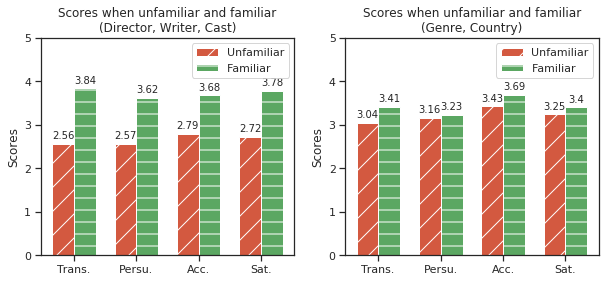

In [70]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
df_ans = df_content[df_content['content_type'].isin(['director', 'cast', 'writer'])].groupby("pre_knowledge").mean()
show_cols_perception = ['transparency', 'persuasiveness', 'interest_accuracy', 'satisfaction']
show_cols_intent =  ['change_click_intent', 'change_watch_intent', 'change_expected_preference']

labels = ['Trans.', 'Persu.', 'Acc.', 'Sat.']
unknown_means = list(df_ans.loc[1, show_cols_perception])
known_means = list(df_ans.loc[2, show_cols_perception])

x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, unknown_means, width, label='Unfamiliar', color="#D35940", hatch='/')
rects2 = ax.bar(x + width/2, known_means, width, label='Familiar', color="#5BA762", hatch='-')

ax.set_ylabel('Scores')
ax.set_title('Scores when unfamiliar and familiar\n(Director, Writer, Cast)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 5)

autolabel(rects1)
autolabel(rects2)

ax = plt.subplot(1, 2, 2)
df_ans = df_content[df_content['content_type'].isin(['other'])].groupby("pre_knowledge").mean()
show_cols_perception = ['transparency', 'persuasiveness', 'interest_accuracy', 'satisfaction']
show_cols_intent =  ['change_click_intent', 'change_watch_intent', 'change_expected_preference']

labels = ['Trans.', 'Persu.', 'Acc.', 'Sat.']
unknown_means = list(df_ans.loc[1, show_cols_perception])
known_means = list(df_ans.loc[2, show_cols_perception])

x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, unknown_means, width, label='Unfamiliar', color="#D35940", hatch='/')
rects2 = ax.bar(x + width/2, known_means, width, label='Familiar', color="#5BA762", hatch='-')

ax.set_ylabel('Scores')
ax.set_title('Scores when unfamiliar and familiar\n(Genre, Country)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 5)

autolabel(rects1)
autolabel(rects2)

plt.savefig("figures/known_2.pdf", dpi=100, bbox_inches="tight")

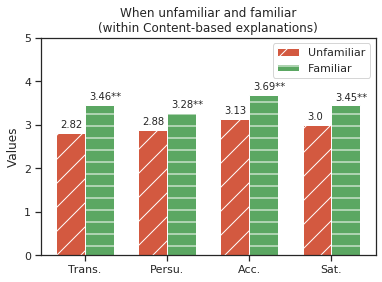

In [37]:
df_ans = df_content.groupby("pre_knowledge").mean()

show_cols_perception = ['transparency', 'persuasiveness', 'interest_accuracy', 'satisfaction']
show_cols_intent =  ['change_click_intent', 'change_watch_intent', 'change_expected_preference']

labels = ['Trans.', 'Persu.', 'Acc.', 'Sat.']
unknown_means = list(df_ans.loc[1, show_cols_perception])
known_means = list(df_ans.loc[2, show_cols_perception])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, unknown_means, width, label='Unfamiliar', color="#D35940", hatch='/')
rects2 = ax.bar(x + width/2, known_means, width, label='Familiar', color="#5BA762", hatch='-')

ax.set_ylabel('Values')
ax.set_title('When unfamiliar and familiar\n(within Content-based explanations)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 5)

def autolabel(rects, sig=False):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}{}'.format(round(height,2), "**" if sig else ""),
                    xy=(rect.get_x()+0.05, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom')


autolabel(rects1)
autolabel(rects2, sig=True)

plt.savefig("figures/known.pdf", dpi=100, bbox_inches="tight")

# Figure: popularity

In [364]:
df_pop = df_explanation[df_explanation['explanation_type'] == "pop"].copy()
df_pop['pop_cnt'] = df_pop['explanation'].map(lambda t: int(re.findall(u"有(\d+)用户", t)[0]))
df_pop['pop_ratio'] = df_pop['explanation'].map(lambda t: int(re.findall(u"热门度前(\d+)%", t)[0]) if u"热门度" in t else np.nan)

In [365]:
col_subjective = ['transparency', 'persuasiveness', 'pre_knowledge', 'interest_accuracy']
col_change = ['change_click_intent', 'change_watch_intent', 'change_expected_preference']

In [377]:
def yerr(X):
    n = len(X)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_se = X_std / np.sqrt(n)
    return X_se

ds_popratio = utils.PDtable()
for tr in range(10):
    # range: [tr*10, tr*10+10]
    idx = (tr*10 <= df_pop["pop_ratio"]) & (df_pop['pop_ratio'] < (tr+1)*10)
    tdf = df_pop[idx]
    
    ds_popratio.add("[{}%:{}%)".format(tr*10, (tr+1)*10), "ratio_range")
    ds_popratio.add(sum(idx), "count")
    for tk in ['satisfaction', 'satisfaction_zscore'] + col_change:
        ds_popratio.add(np.mean(tdf[tk]), tk)
        ds_popratio.add(yerr(tdf[tk]), tk + "_err")
        ds_popratio.add(np.mean(tdf[tk]) - yerr(tdf[tk]), tk + "_low")
        ds_popratio.add(np.mean(tdf[tk]) + yerr(tdf[tk]), tk + "_high")
    ds_popratio.add(np.mean(tdf['satisfaction'] > 3), "sat_ratio")
    
df_popratio = ds_popratio.to_pandas()

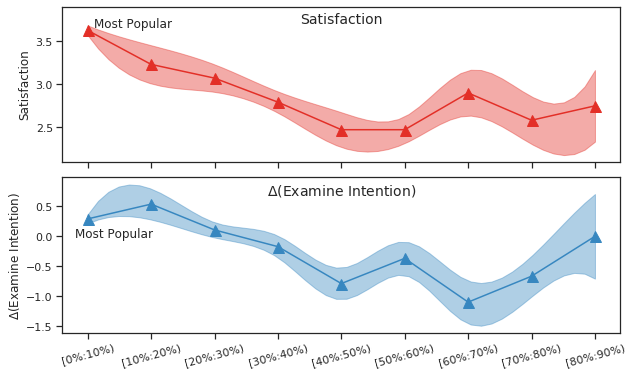

In [379]:
from scipy.interpolate import interp1d

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
fun_low = interp1d(range(9), np.array(df_popratio['satisfaction_low'])[:-1], kind='cubic')
fun_high = interp1d(range(9), np.array(df_popratio['satisfaction_high'])[:-1], kind='cubic')

plt.plot(range(9), np.array(df_popratio['satisfaction'])[:-1], '-', color=red, label="EQ:High", marker="^", markersize=11)
xnew = np.linspace(0, 8, 50)
plt.fill_between(xnew, fun_low(xnew), fun_high(xnew), alpha=0.4, color=red)
plt.xticks(range(9), ["" for _ in range(9)])
plt.ylabel("Satisfaction")
plt.title("Satisfaction", y=0.85, fontsize=14)
plt.text(0.1, np.array(df_popratio['satisfaction'])[0] + 0., "Most Popular", 
         horizontalalignment='left', verticalalignment='bottom', fontsize=12)
# plt.text(8+0.4, np.array(df_popratio['satisfaction'])[-2] + 0.05, "Least Popular", 
#          horizontalalignment='right', verticalalignment='bottom', fontsize=12)
plt.ylim(2.1, 3.9)

plt.subplot(2, 1, 2)
fun_low = interp1d(range(9), np.array(df_popratio['change_click_intent_low'])[:-1], kind='cubic')
fun_high = interp1d(range(9), np.array(df_popratio['change_click_intent_high'])[:-1], kind='cubic')

plt.plot(range(9), np.array(df_popratio['change_click_intent'])[:-1], '-', color=blue, label="EQ:High", marker="^", markersize=11)
xnew = np.linspace(0, 8, 50)
plt.fill_between(xnew, fun_low(xnew), fun_high(xnew), alpha=0.4, color=blue)
plt.ylabel("$\Delta$(Examine Intention)")
plt.title("$\Delta$(Examine Intention)", y=0.85, fontsize=14)
plt.xticks(range(9), ["[{}%:{}%)".format(tr*10, (tr+1)*10) for tr in range(9)], rotation=15)
plt.text(-0.2, np.array(df_popratio['change_click_intent'])[0] - 0.15, "Most Popular", 
         horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.savefig("figures/popular.pdf", dpi=100, bbox_inches="tight")

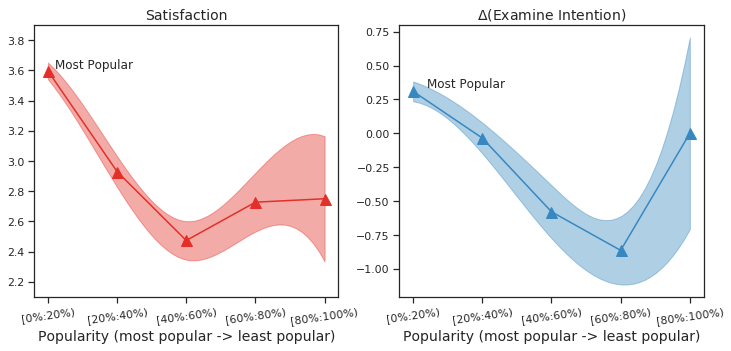

In [400]:
def yerr(X):
    n = len(X)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_se = X_std / np.sqrt(n)
    return X_se

ds_popratio = utils.PDtable()
for tr in range(5):
    # range: [tr*10, tr*10+10]
    idx = (tr*20 <= df_pop["pop_ratio"]) & (df_pop['pop_ratio'] < (tr+1)*20)
    tdf = df_pop[idx]
    
    ds_popratio.add("[{}%:{}%)".format(tr*20, (tr+1)*20), "ratio_range")
    ds_popratio.add(sum(idx), "count")
    for tk in ['satisfaction', 'satisfaction_zscore'] + col_change:
        ds_popratio.add(np.mean(tdf[tk]), tk)
        ds_popratio.add(yerr(tdf[tk]), tk + "_err")
        ds_popratio.add(np.mean(tdf[tk]) - yerr(tdf[tk]), tk + "_low")
        ds_popratio.add(np.mean(tdf[tk]) + yerr(tdf[tk]), tk + "_high")
    ds_popratio.add(np.mean(tdf['satisfaction'] > 3), "sat_ratio")
    
df_popratio = ds_popratio.to_pandas()


from scipy.interpolate import interp1d

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fun_low = interp1d(range(5), np.array(df_popratio['satisfaction_low']), kind='cubic')
fun_high = interp1d(range(5), np.array(df_popratio['satisfaction_high']), kind='cubic')

plt.plot(range(5), np.array(df_popratio['satisfaction']), '-', color=red, label="EQ:High", marker="^", markersize=11)
xnew = np.linspace(0, 4, 50)
plt.fill_between(xnew, fun_low(xnew), fun_high(xnew), alpha=0.4, color=red)
plt.xticks(range(5), ["" for _ in range(5)])
# plt.ylabel("Satisfaction")
plt.title("Satisfaction", fontsize=14)
plt.text(0.1, np.array(df_popratio['satisfaction'])[0] + 0., "Most Popular", 
         horizontalalignment='left', verticalalignment='bottom', fontsize=12)
plt.xticks(range(5), ["[{}%:{}%)".format(tr*20, (tr+1)*20) for tr in range(5)], rotation=8)
plt.xlabel("Popularity (most popular -> least popular)", fontsize=14)

# plt.text(8+0.4, np.array(df_popratio['satisfaction'])[-2] + 0.05, "Least Popular", 
#          horizontalalignment='right', verticalalignment='bottom', fontsize=12)
plt.ylim(2.1, 3.9)

plt.subplot(1, 2, 2)
fun_low = interp1d(range(5), np.array(df_popratio['change_click_intent_low']), kind='cubic')
fun_high = interp1d(range(5), np.array(df_popratio['change_click_intent_high']), kind='cubic')

plt.plot(range(5), np.array(df_popratio['change_click_intent']), '-', color=blue, label="EQ:High", marker="^", markersize=11)
xnew = np.linspace(0, 4, 50)
plt.fill_between(xnew, fun_low(xnew), fun_high(xnew), alpha=0.4, color=blue)
# plt.ylabel("$\Delta$(Examine Intention)")
plt.title("$\Delta$(Examine Intention)", fontsize=14)
plt.xlabel("Popularity (most popular -> least popular)", fontsize=14)
plt.xticks(range(5), ["[{}%:{}%)".format(tr*20, (tr+1)*20) for tr in range(5)], rotation=8)
plt.text(0.2, np.array(df_popratio['change_click_intent'])[0]+0.1, "Most Popular", 
         horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.savefig("figures/popular.pdf", dpi=100, bbox_inches="tight")

In [298]:
df_popratio

,ratio_range,count,satisfaction,satisfaction_err,satisfaction_low,satisfaction_high,satisfaction_zscore,satisfaction_zscore_err,satisfaction_zscore_low,satisfaction_zscore_high,...,change_click_intent_high,change_watch_intent,change_watch_intent_err,change_watch_intent_low,change_watch_intent_high,change_expected_preference,change_expected_preference_err,change_expected_preference_low,change_expected_preference_high,sat_ratio
0,[0%:10%),168,3.625000,0.056273,3.568727,3.681273,0.282478,0.063705,0.218773,0.346184,...,0.367594,0.375000,0.070272,0.304728,0.445272,0.166667,0.050273,0.116393,0.216940,0.607143
1,[10%:20%),13,3.230769,0.221716,3.009053,3.452485,-0.211242,0.287425,-0.498666,0.076183,...,0.796249,0.307692,0.167989,0.139703,0.475681,-0.153846,0.100068,-0.253914,-0.053778,0.307692
2,[20%:30%),28,3.071429,0.159148,2.912281,3.230576,-0.170847,0.166845,-0.337692,-0.004003,...,0.234311,0.178571,0.182483,-0.003911,0.361054,0.107143,0.136831,-0.029688,0.243974,0.321429
3,[30%:40%),29,2.793103,0.123170,2.669934,2.916273,-0.558170,0.123914,-0.682085,-0.434256,...,0.010501,-0.241379,0.134926,-0.376305,-0.106454,-0.275862,0.137036,-0.412898,-0.138826,0.137931
4,[40%:50%),19,2.473684,0.202045,2.271639,2.675729,-0.570093,0.144538,-0.714631,-0.425555,...,-0.525486,-0.157895,0.134456,-0.292351,-0.023439,-0.473684,0.114549,-0.588233,-0.359135,0.105263
5,[50%:60%),19,2.473684,0.155569,2.318115,2.629253,-0.843470,0.205610,-1.049080,-0.637860,...,-0.087835,-0.315789,0.268912,-0.584702,-0.046877,-0.421053,0.171611,-0.592664,-0.249442,0.052632
6,[60%:70%),10,2.900000,0.262679,2.637321,3.162679,-0.335373,0.265952,-0.601325,-0.069421,...,-0.740834,-0.700000,0.317805,-1.017805,-0.382195,-0.300000,0.246982,-0.546982,-0.053018,0.300000
7,[70%:80%),12,2.583333,0.275336,2.307997,2.858670,-0.865849,0.333282,-1.199132,-0.532567,...,-0.326460,-0.500000,0.300463,-0.800463,-0.199537,-0.250000,0.291667,-0.541667,0.041667,0.250000
8,[80%:90%),4,2.750000,0.414578,2.335422,3.164578,-0.827377,0.483005,-1.310382,-0.344372,...,0.707107,0.000000,0.790569,-0.790569,0.790569,0.000000,0.353553,-0.353553,0.353553,0.250000
9,[90%:100%),0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
(168 + 13 + 28  + 10 + 12 + 4) / 310

0.7580645161290323

In [301]:
! = 3, 4, 5

/bin/sh: 1: =: not found
